# Import

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy.wcs import WCS
from ClusterModel import model

# Define a cluster object

In [2]:
clust = model.Cluster(name='Coma', redshift=0.023, M500=7e14*u.Msun, cosmology=cosmo, silent=True)
clust.output_dir = '/Users/adam/Desktop/test' # Where to dave outputs
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

In [3]:
# Define the relevant model parameters (target and CRp)
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}
clust.density_crp_model = {'name':'beta', 'beta':2.0/3, 'r_c':290*u.kpc}
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}
clust.X_cr = {'X':0.01, 'Rcut':clust.R500}

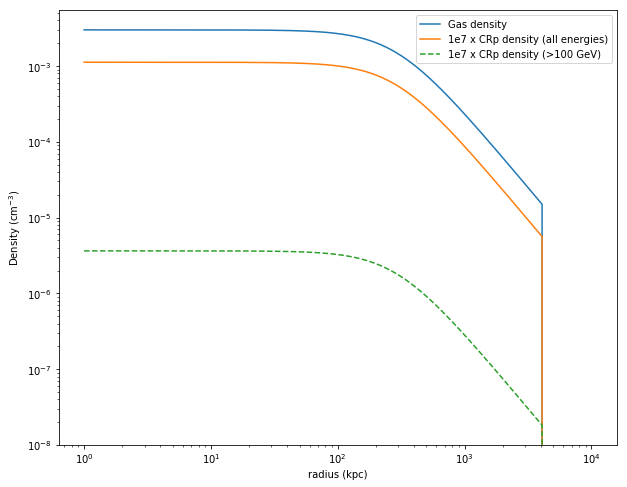

In [4]:
# Check the densities
plt.figure(figsize=(10,8))
r, n_gas_r = clust.get_density_gas_profile()
plt.loglog(r, n_gas_r, label='Gas density')
r, n_crp_r = clust.get_density_crp_profile()
plt.loglog(r, 1e7*n_crp_r, label='1e7 x CRp density (all energies)')
r, n_crp_r = clust.get_density_crp_profile(Emin=100*u.GeV, Emax=100*u.PeV)
plt.loglog(r, 1e7*n_crp_r, '--', label='1e7 x CRp density (>100 GeV)')
plt.xlabel('radius (kpc)')
plt.ylabel('Density (cm$^{-3}$)')
plt.legend()

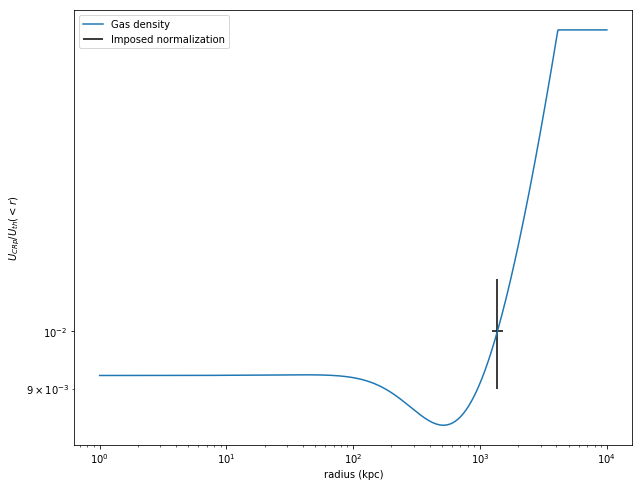

In [5]:
# Check the CR to thermal energy (thermal energy is derived from pressure profile)
plt.figure(figsize=(10,8))
r, x_r = clust.get_crp_to_thermal_energy_profile(Emin=None, Emax=None)
plt.loglog(r, x_r, label='Gas density')
plt.vlines(clust.X_cr['Rcut'].to_value('kpc'), clust.X_cr['X']*0.9, clust.X_cr['X']*1.1, label='Imposed normalization')
plt.hlines(clust.X_cr['X'], clust.X_cr['Rcut'].to_value('kpc')*0.9, clust.X_cr['Rcut'].to_value('kpc')*1.1)
plt.xlabel('radius (kpc)')
plt.ylabel('$U_{CRp}/U_{th} (<r)$')
plt.legend()

# Extract the spectrum

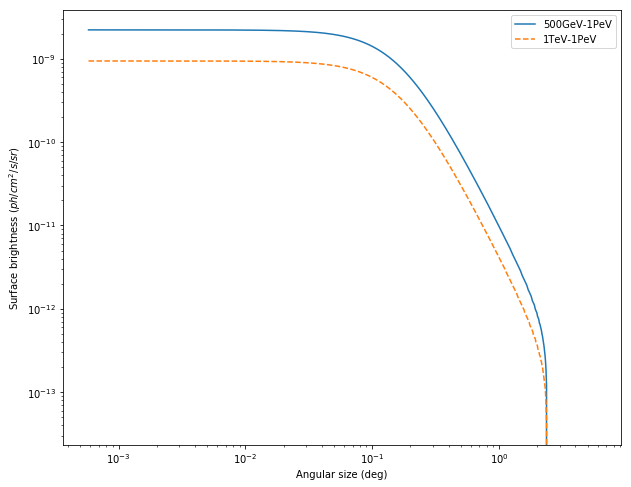

In [6]:
r1, p1 = clust.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                   Emin=500*u.GeV, Emax=1*u.PeV, Energy_density=False,
                                   NR500max=5.0, Npt_los=100)
r2, p2 = clust.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                   Emin=1000*u.GeV, Emax=1*u.PeV, Energy_density=False,
                                   NR500max=3, Npt_los=100)
plt.figure(0,figsize=(10,8))
plt.loglog((r1/clust.D_ang*u.rad).to('deg'),p1.to('cm-2 s-1 sr-1'), '-', label='500GeV-1PeV')
plt.loglog((r2/clust.D_ang*u.rad).to('deg'),p2.to('cm-2 s-1 sr-1'), '--', label='1TeV-1PeV')
plt.xlabel('Angular size (deg)')
plt.ylabel('Surface brightness ($ph/cm^2/s/sr$)')
plt.legend()

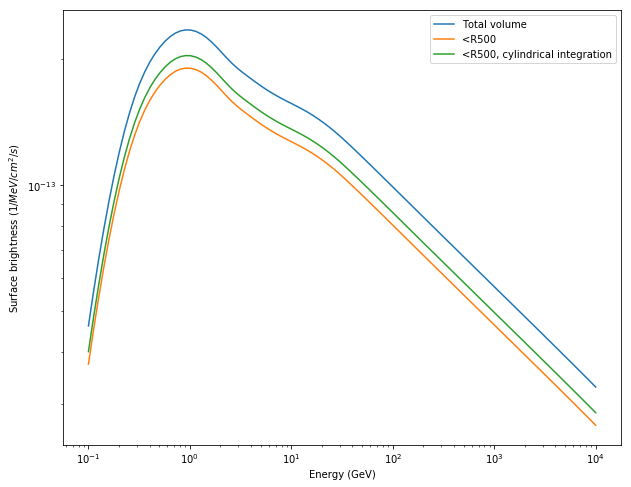

In [7]:
energy = np.logspace(-1,4,100)*u.GeV
e1, s1 = clust.get_gamma_spectrum(energy,Rmax=clust.R_truncation, type_integral='spherical', NR500max=5.0, Npt_los=100)
e2, s2 = clust.get_gamma_spectrum(energy,Rmax=clust.R500, type_integral='spherical', NR500max=5.0, Npt_los=100)
e3, s3 = clust.get_gamma_spectrum(energy,Rmax=clust.R500, type_integral='cylindrical', NR500max=5.0, Npt_los=100)

plt.figure(0,figsize=(10,8))
plt.loglog(e1, e1**2*s1, '-', label='Total volume')
plt.loglog(e2, e2**2*s2, '-', label='<R500')
plt.loglog(e3, e3**2*s3, '-', label='<R500, cylindrical integration')
plt.xlabel('Energy (GeV)')
plt.ylabel('Surface brightness ($1/MeV/cm^2/s$)')
plt.legend()

# Compute the gamma ray map template

In [8]:
clust.map_reso = 0.01*u.deg
clust.map_fov = 5.0*u.deg
clust.map_coord = clust.coord
header = clust.get_map_header()

template = clust.get_gamma_template_map().to_value('sr-1')

Text(0.5,1,'Coma, gamma template ($sr^{-1}$)')

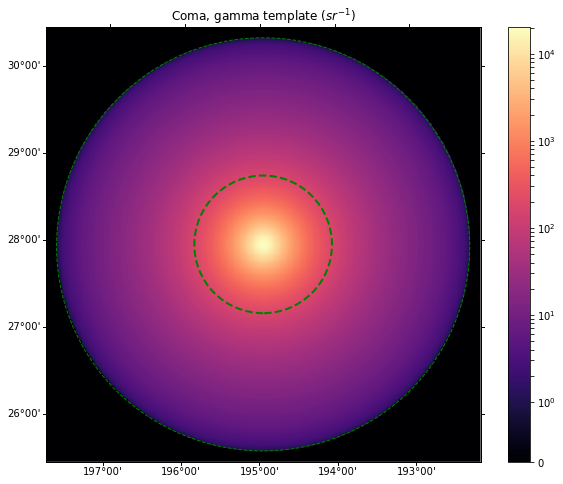

In [9]:
fig = plt.figure(figsize=(10, 8))
rad500 = clust.theta500.to_value('deg')
radtru = clust.theta_truncation.to_value('deg')
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(template, vmin=0, origin='lower', cmap='magma', norm=SymLogNorm(1))
circle500 = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*rad500/np.cos(clust.coord.dec.value*np.pi/180), 2*rad500,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
circletru = matplotlib.patches.Ellipse((clust.coord.ra.value, clust.coord.dec.value),
                                        2*radtru/np.cos(clust.coord.dec.value*np.pi/180), 2*radtru,
                                        linewidth=1, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle500)
ax.add_patch(circletru)
plt.colorbar()
plt.title(clust.name+', gamma template ($sr^{-1}$)')

# Save outputs

In [10]:
# Save the parameters
clust.save_param()

# Save relevant output products
clust.save_spectra()
clust.save_profile()
clust.save_map()

# Can also produce plots
clust.plot(prod_list=['all'])

/Users/adam/anaconda2/envs/cta/lib/python2.7/site-packages/numpy/ma/core.py:6666: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
